<a href="https://colab.research.google.com/github/Jackyscy/cv/blob/main/CNN_trial_multiD1_800.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, \
  GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate, Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D,Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

In [39]:
df = pd.read_csv('GT data for 3-hour intervel learning1_without_temp_selected_screened.csv',
                 usecols=['Combust Monitor Actual Spread 1','GT Exhaust Outlet Temp', 'GT Exhaust Outlet temp Expected',
                 'Combust Monitor Actual Spread 3', 'GT Exhaust Outlet temp Average',
                  'GT Swirl Angle',
                  'GT Efficiency Actual (LHV)','Turbine Speed in RPM',
                  'GT Compres Disch Press','GT Fuel Gas Mass Flow','GT IGV Position',
                  'GT Turbine Inlet Temp','GT Gross MW']
        )


In [40]:
df["LogSpread1"] = np.log(df['Combust Monitor Actual Spread 1'])
df['DiffLogSpread1'] = df['LogSpread1'].diff()

In [41]:
#df = df.drop(df.index[0])

df.head()

,Combust Monitor Actual Spread 1,GT Exhaust Outlet Temp,GT Exhaust Outlet temp Expected,Combust Monitor Actual Spread 3,GT Exhaust Outlet temp Average,GT Swirl Angle,GT Efficiency Actual (LHV),Turbine Speed in RPM,GT Compres Disch Press,GT Fuel Gas Mass Flow,GT IGV Position,GT Turbine Inlet Temp,GT Gross MW,LogSpread1,DiffLogSpread1
0,31.056818,621.798584,603.800964,21.286,621.798584,34.020233,33.718552,2997.721680,1506.065918,12.966751,87.996284,1246.550537,211.845764,3.435818,NaN
1,29.123943,622.049377,605.027405,18.389,622.049377,34.331245,33.759861,2998.596436,1495.955322,12.882809,87.994431,1247.431152,211.376907,3.371561,-0.064258
2,29.981073,622.694458,604.687195,19.029,622.694458,33.852203,33.689831,3002.304688,1503.727417,12.721853,87.991333,1247.777954,212.360016,3.400566,0.029006
3,29.942198,623.366028,605.127502,21.430,623.366028,35.938599,33.681320,2998.558350,1492.666870,12.585037,88.001442,1248.785034,209.649109,3.399269,-0.001298
4,27.763840,622.350586,605.055359,18.390,622.350586,35.666512,33.540955,3001.869141,1484.694092,12.714616,88.000969,1246.161621,210.130875,3.323734,-0.075534


In [42]:
df.shape[1]

15

In [43]:
#input_data = df[['GT Exhaust Outlet Temp', 'GT Exhaust Outlet temp Expected',
               #  'Combust Monitor Actual Spread 3', 'GT Exhaust Outlet temp Average',
               #   'GT Swirl Angle', 'GT Exhaust Outlet Temp',
               #   'GT Efficiency Actual (LHV)','Turbine Speed in RPM',
               #   'GT Compres Disch Press','GT Fuel Gas Mass Flow','GT IGV Position',
               #   'GT Turbine Inlet Temp','GT Gross MW',
               #  'LogSpread1','DiffLogSpread1' ]].values

#targets =df['DiffLogSpread1'].values

In [44]:
#input_data.shape

df.shape

(2858, 15)

In [45]:
#targets =df['DiffLogSpread1'].values

In [46]:
#T = 10
#D = input_data.shape[1]
#N = len(input_data)-T

T = 10
D = df.shape[1]
N = len(df)-T


In [47]:
#Ntest = 21
#train = input_data[:-Ntest]
#test = input_data[-Ntest:]
#train.shape

Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
train.shape


(2837, 15)

In [48]:
#boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [49]:
# Make supervised dataset

input_data = df[['Combust Monitor Actual Spread 1','GT Exhaust Outlet Temp', 'GT Exhaust Outlet temp Expected',
                 'Combust Monitor Actual Spread 3', 'GT Exhaust Outlet temp Average',
                  'GT Swirl Angle',
                  'GT Efficiency Actual (LHV)','Turbine Speed in RPM',
                  'GT Compres Disch Press','GT Fuel Gas Mass Flow','GT IGV Position',
                  'GT Turbine Inlet Temp','GT Gross MW',"LogSpread1",'DiffLogSpread1'
                ]].dropna().to_numpy()

targets =df['DiffLogSpread1'].dropna().to_numpy()


X = []
Y = []
for t in range(len(input_data) - T):
  x = input_data[t:t+T,:]
  X.append(x)
  y = targets[t+T]

  Y.append(y)

X = np.array(X).reshape(-1, T, D)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2847, 10, 15) Y.shape (2847,)


In [50]:
#Xtrain = np.zeros((len(input_data)-Ntest,T,D))
#Ytrain = np.zeros(len(input_data)-Ntest)

#for t in range (len(input_data)-Ntest):
  #Xtrain[t,:,:] = input_data[t:t+T]
  #Ytrain[t] = (targets[t+T])

In [51]:
#Xtest = np.zeros((Ntest, T, D))
#Ytest = np.zeros(Ntest)

#for u in range(Ntest):
 # t = u + len(input_data)-Ntest
 # Xtest[u,:,:] = input_data[t:t+T]
 # Ytest[u] = (targets[t+T])

In [52]:
Xtrain, Ytrain = X[:-Ntest,:,:], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:,:,:], Y[-Ntest:]


In [53]:
# CNN
i = Input(shape=(T, D))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [54]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10, 15)]          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 8, 16)             736       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 4, 16)             0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 33    

In [55]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [57]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=800,
  validation_data=(Xtest, Ytest)
)

Epoch 1/800
89/89 [==============================] - 0s 2ms/step - loss: 9.4735 - val_loss: 3.3540
Epoch 2/800
89/89 [==============================] - 0s 2ms/step - loss: 6.5449 - val_loss: 3.5527
Epoch 3/800
89/89 [==============================] - 0s 2ms/step - loss: 7.5427 - val_loss: 9.7796
Epoch 4/800
89/89 [==============================] - 0s 2ms/step - loss: 6.7513 - val_loss: 3.4859
Epoch 5/800
89/89 [==============================] - 0s 2ms/step - loss: 7.1279 - val_loss: 4.0552
Epoch 6/800
89/89 [==============================] - 0s 2ms/step - loss: 8.6312 - val_loss: 2.9010
Epoch 7/800
89/89 [==============================] - 0s 2ms/step - loss: 6.7002 - val_loss: 3.0282
Epoch 8/800
89/89 [==============================] - 0s 2ms/step - loss: 5.7249 - val_loss: 6.9103
Epoch 9/800
89/89 [==============================] - 0s 2ms/step - loss: 6.1016 - val_loss: 11.0361
Epoch 10/800
89/89 [==============================] - 0s 2ms/step - loss: 5.9172 - val_loss: 3.0921
Epoch 11

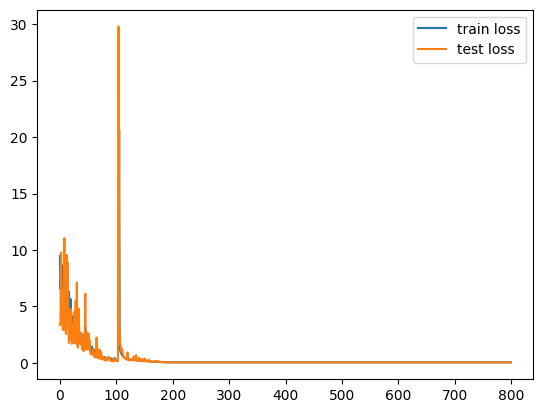

In [58]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [59]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [60]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 19ms/step


In [61]:
# Store diff predictions
df.loc[train_idx, 'Diff CNN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff CNN Test Prediction'] = Ptest

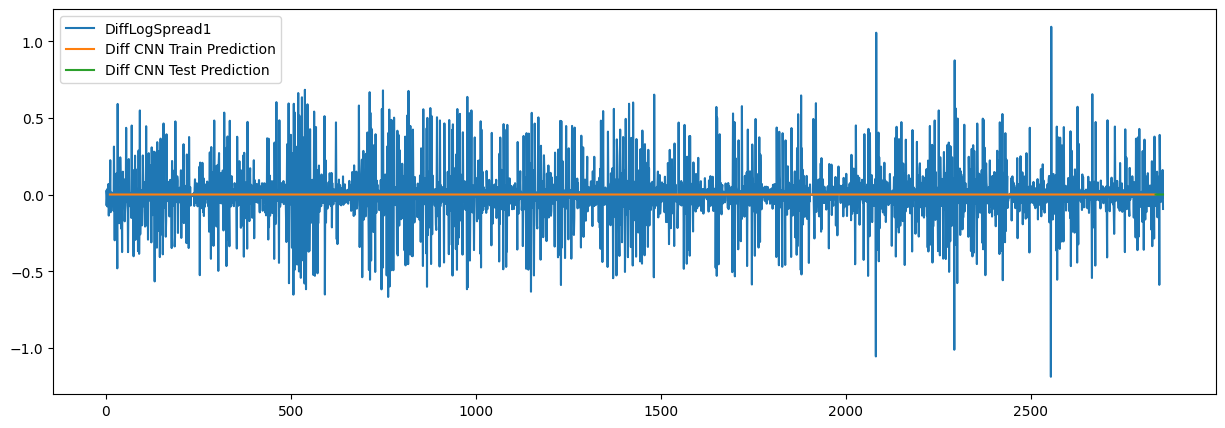

In [62]:
cols = ['DiffLogSpread1',
        'Diff CNN Train Prediction',
        'Diff CNN Test Prediction']
df[cols].plot(figsize=(15, 5));


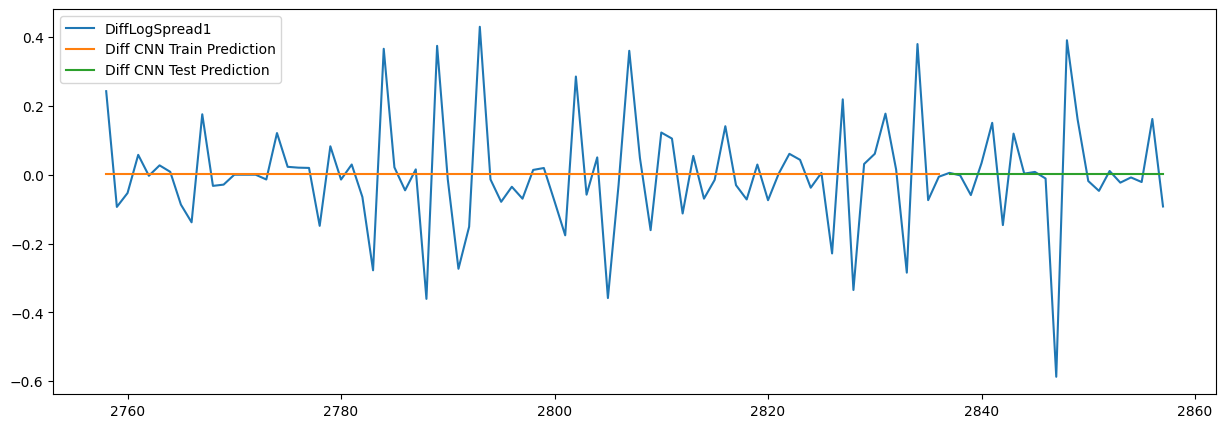

In [63]:
# plot 1-step forecast
df.iloc[-100:][['DiffLogSpread1', 'Diff CNN Train Prediction', 'Diff CNN Test Prediction']].plot(figsize=(15, 5));

In [64]:
# Needed to compute un-differenced predictions
df['ShiftLogSpread1'] = df['LogSpread1'].shift(1)
prev = df['ShiftLogSpread1']

In [65]:
# Last-known train value
last_train = train.iloc[-1]['LogSpread1']

In [66]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

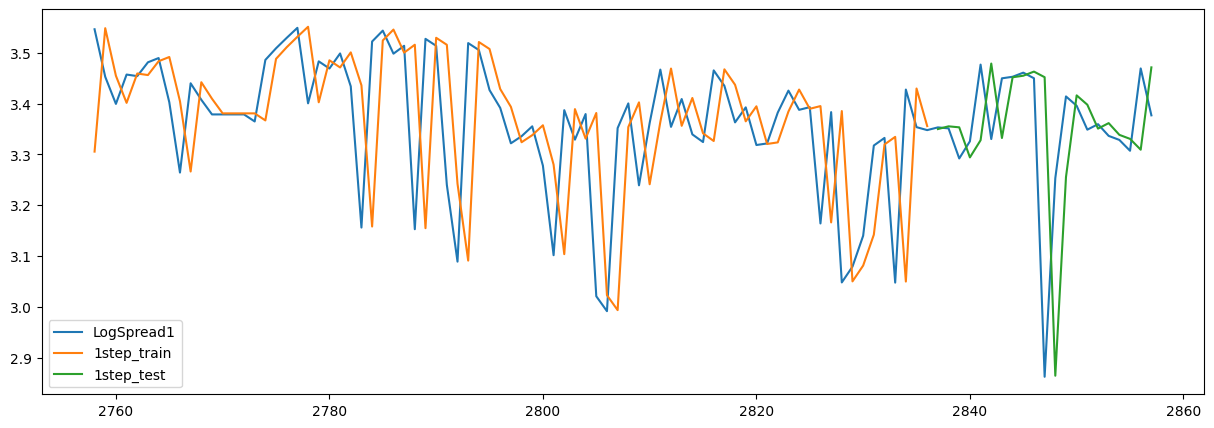

In [67]:
# plot 1-step forecast
df.iloc[-100:][['LogSpread1', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [68]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, D))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 19ms/step


In [69]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

In [70]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

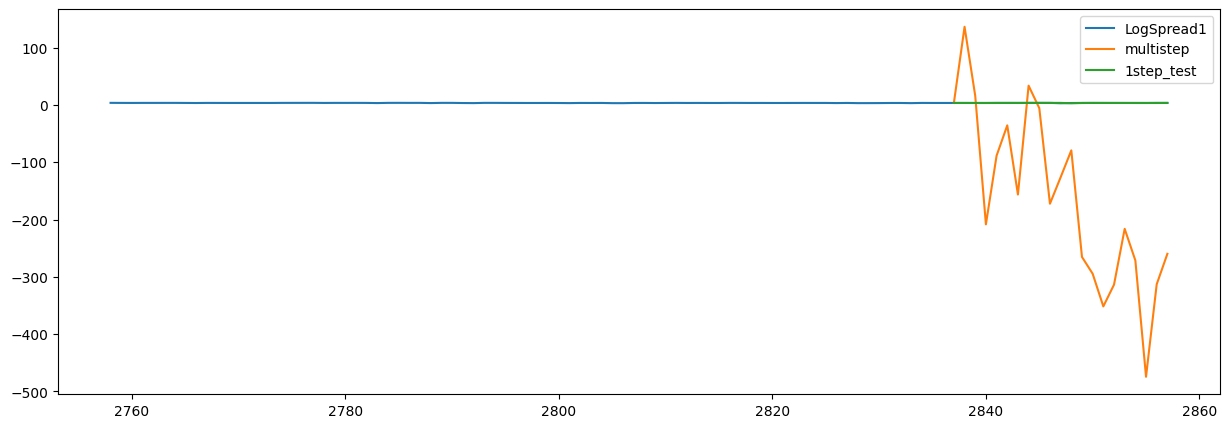

In [71]:
# plot 1-step and multi-step forecast
df.iloc[-100:][['LogSpread1', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [72]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(input_data) - Tx - Ty + 1):
  x = input_data[t:t+Tx]
  X.append(x)
  y = targets[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, D)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2827, 10, 15) Y.shape (2827, 21)


In [73]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [74]:
# CNN
i = Input(shape=(Tx, D))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [75]:
model.compile(
 loss='mse',
 optimizer='adam',
)

In [77]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=800,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/800
89/89 [==============================] - 0s 2ms/step - loss: 20.4462 - val_loss: 10.1965
Epoch 2/800
89/89 [==============================] - 0s 2ms/step - loss: 19.2038 - val_loss: 18.3988
Epoch 3/800
89/89 [==============================] - 0s 2ms/step - loss: 18.3978 - val_loss: 11.2099
Epoch 4/800
89/89 [==============================] - 0s 2ms/step - loss: 17.1995 - val_loss: 6.3972
Epoch 5/800
89/89 [==============================] - 0s 2ms/step - loss: 16.3302 - val_loss: 8.5251
Epoch 6/800
89/89 [==============================] - 0s 2ms/step - loss: 15.5549 - val_loss: 7.1076
Epoch 7/800
89/89 [==============================] - 0s 2ms/step - loss: 15.0896 - val_loss: 8.3116
Epoch 8/800
89/89 [==============================] - 0s 2ms/step - loss: 14.3259 - val_loss: 5.5308
Epoch 9/800
89/89 [==============================] - 0s 2ms/step - loss: 13.7246 - val_loss: 6.6834
Epoch 10/800
89/89 [==============================] - 0s 2ms/step - loss: 13.3435 - val_loss: 7.5

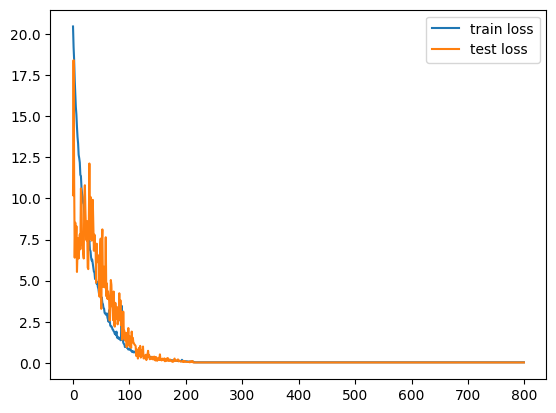

In [78]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [79]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

1/1 [==============================] - 0s 21ms/step


In [80]:
Ptrain.shape, Ptest.shape

((2826, 21), (1, 21))

In [81]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

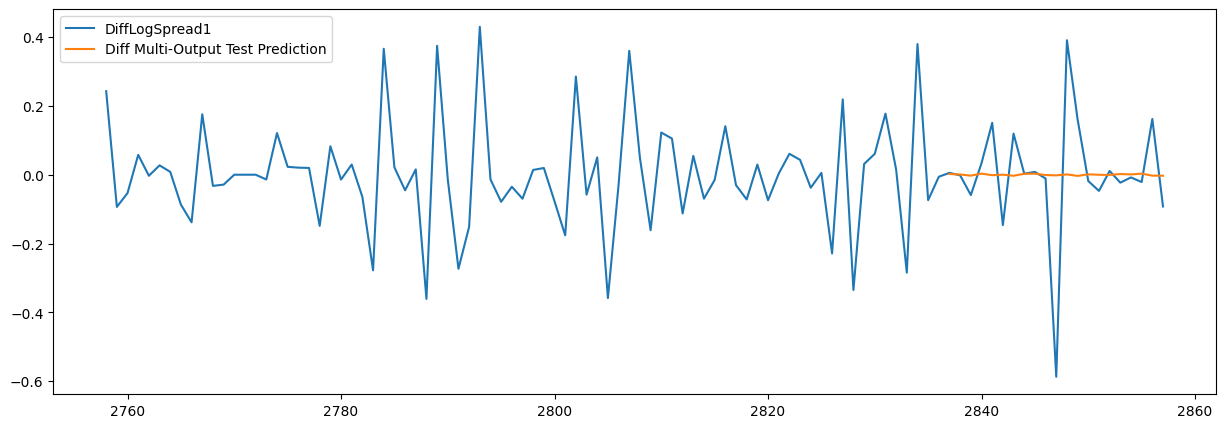

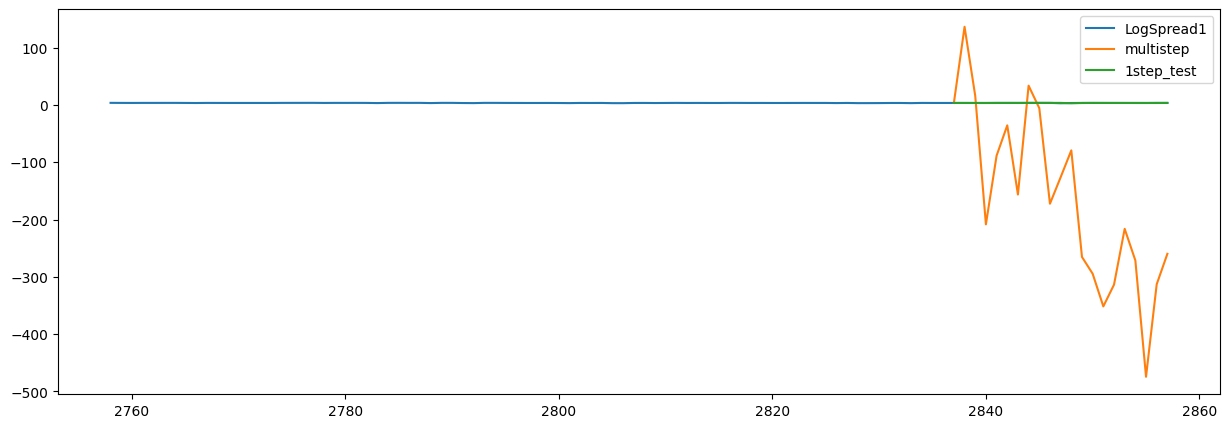

In [82]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest
cols = ['DiffLogSpread1', 'Diff Multi-Output Test Prediction']
df[-100:][cols].plot(figsize=(15, 5));

df.iloc[-100:][['LogSpread1', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [83]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
 np.cumsum(Ptest)

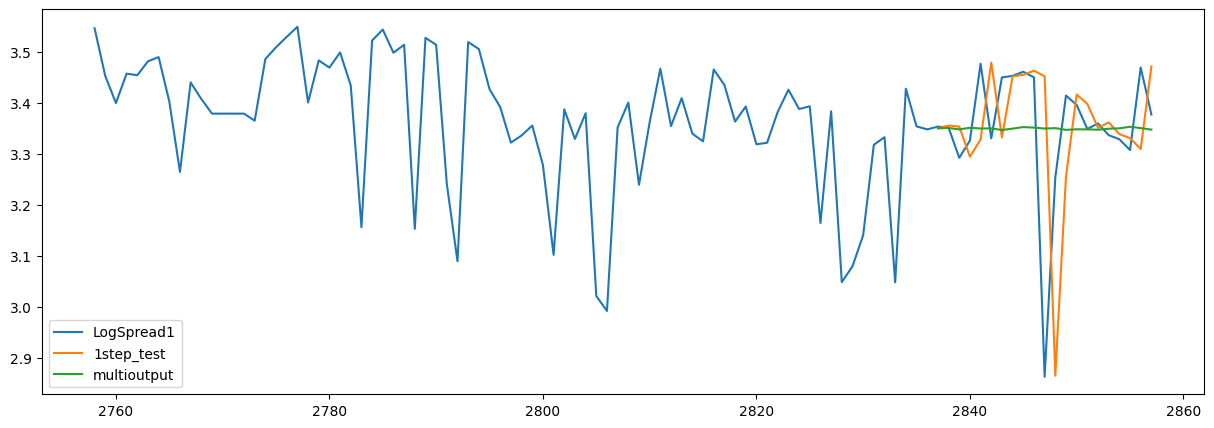

In [84]:
# plot all forecasts '1step_test','multistep'
cols = ['LogSpread1', '1step_test', 'multioutput']
df.iloc[-100:][cols].plot(figsize=(15, 5));

In [85]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogSpread1']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 54.92546056364743
multi-output MAPE: 0.023447641937534097
